In [1]:
%matplotlib inline

import torchvision
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import transforms
from torchvision.datasets.utils import download_url
import os
import tarfile
import hashlib
import numpy as np
import queue

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [3]:
device

device(type='cuda')

# ⬇️ Download Dataset

Most of this is copied from Tutorial 4

In [4]:
# https://github.com/fastai/imagenette
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz'
dataset_filename = dataset_url.split('/')[-1]
dataset_foldername = dataset_filename.split('.')[0]
data_path = './data'
dataset_filepath = os.path.join(data_path,dataset_filename)
dataset_folderpath = os.path.join(data_path,dataset_foldername)

os.makedirs(data_path, exist_ok=True)

download = False
if not os.path.exists(dataset_filepath):
    download = True
else:
    md5_hash = hashlib.md5()


    file = open(dataset_filepath, "rb")

    content = file.read()

    md5_hash.update(content)


    digest = md5_hash.hexdigest()
    if digest != 'fe2fc210e6bb7c5664d602c3cd71e612':
        download = True
if download:
    download_url(dataset_url, data_path)

with tarfile.open(dataset_filepath, 'r:gz') as tar:
    tar.extractall(path=data_path)

In [5]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

    def __repr__(self):
        format_string = self.__class__.__name__ + '(\n\t'
        format_string += self.base_transform.__repr__().replace('\n', '\n\t')
        format_string += '\n)'
        return format_string

In [27]:
size  = 224
ks = (int(0.1 * size) // 2) * 2 + 1 # should be odd
__imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                    'std': [0.229, 0.224, 0.225]}

train_transform = TwoCropsTransform(transforms.Compose([transforms.RandomResizedCrop(scale=(0.2, 1), size=size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
                                      transforms.RandomGrayscale(p=0.2),
                                      transforms.GaussianBlur(kernel_size=ks),
                                      transforms.ToTensor(),
                                      transforms.Normalize(**__imagenet_stats)
                                    ]))
downstream_trainsform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)
                                           ])

image_folder_dir = os.path.join(dataset_folderpath,'train')
dataset_train = torchvision.datasets.ImageFolder(image_folder_dir, train_transform)
#valid_ds = ImageFolder('./data/imagenette-160/val', valid_tfms)

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=batch_size,
        num_workers=6,
        #drop_last=True,
        #shuffle=True,
)


In [21]:
dataset_train.classes

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [7]:
def get_numpy_samples(inputs):
        mean = torch.as_tensor(__imagenet_stats['mean'], dtype=inputs.dtype, device=inputs.device)
        std = torch.as_tensor(__imagenet_stats['std'], dtype=inputs.dtype, device=inputs.device)
        inputs = inputs * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)
        inputs = inputs.numpy()
        inputs = np.transpose(inputs, (0,2,3,1))
        return inputs

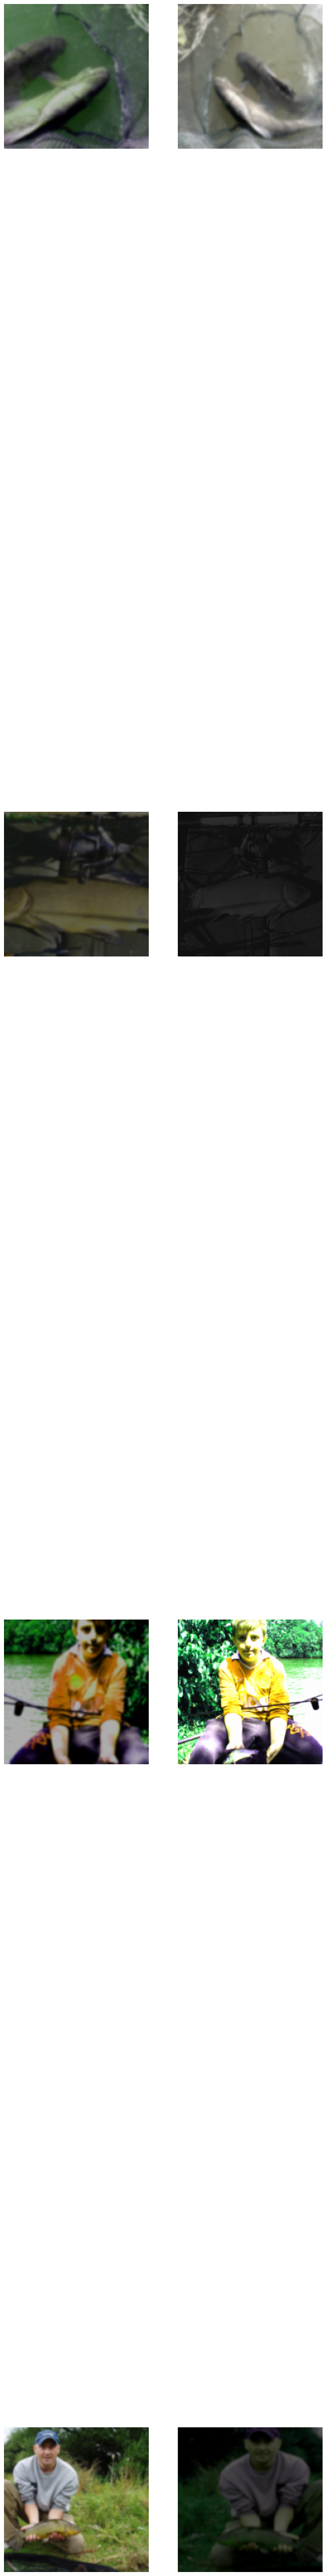

In [8]:
fig, axes = plt.subplots(nrows=batch_size, ncols=2, figsize=(10,100))
for (input1, input2), _ in train_dataloader:
    np_inputs1, np_inputs2 = get_numpy_samples(input1), get_numpy_samples(input2)
    for row in range(batch_size):
        axes[row, 0].axis("off")
        axes[row, 0].imshow(np_inputs1[row])
        axes[row, 1].axis("off")
        axes[row, 1].imshow(np_inputs2[row])
    break
plt.show()

# 🧪 MOCO

In [9]:
class MOCO(nn.Module):
    def __init__(self, base_network, C, K, t, m, device):
        super().__init__()
        self.f_q = base_network # query encoder
        self.f_k = base_network # key encoder
        self.queue = torch.zeros((C, K)).to(device) # holds minibatches (features)
        self.t = t
        self.m = m
        self.device = device
    
    def forward(self, x_q, x_k):
        q = self.f_q(x_q) # queries
        k = self.f_k(x_k) # keys
        k = k.detach() # no gradient to keys
        return q, k
    
    def loss(self, q, k):
        N = q.shape[0]
        
        # positive logits: Nx1
        # unsqueezing is the same as view() in the paper
        l_pos = torch.bmm(q.unsqueeze(1), k.unsqueeze(-1)).squeeze(-1) # Nx1
        l_neg = torch.mm(q, self.queue) # NxC * CxK = NxK
        
        # cat([Nx1, NxK]) = Nx(K+1)
        logits = torch.cat([l_pos, l_neg], dim=1)
        
        labels = torch.zeros(N).type(torch.LongTensor).to(device)
        
        loss = F.cross_entropy(logits/self.t, labels)
        
        return loss
        
    def momentum_update(self):
        ''' 
        Updates f_k with momentum update.
        Do this only after updating f_q 
        '''
        with torch.no_grad():
            for (p_k, p_q) in zip(self.f_k.parameters(), self.f_q.parameters()):
                new_param_value = self.m * p_k + (1-self.m) * p_q
                p_k.copy_(new_param_value)

        
    def update_queue(self, k):
        # queue is NxK
        # need to roll by batch size, then replace with curr batch
        
        # k.t() is CxN
        batch_size = k.shape[0] # N
        
        self.queue = self.queue.roll(batch_size, 1)
        self.queue[:, :batch_size] = k.t()
        
        

# 🏋️‍♂️ Train

In [10]:
### Hyperparams ###

K = 500 # number of keys in dict
C = 128 # feature dim
t = 0.07 # temperature
m = 0.99 # momentum (for updating key encoder)

In [11]:
resnet18 = torchvision.models.resnet18(num_classes=C, pretrained=False)

In [12]:
moco = MOCO(base_network=resnet18, C=C, K=K, t=t, m=m, device=device).to(device)

In [13]:
optimizer = torch.optim.Adam(moco.f_q.parameters(), lr=3e-4)

In [14]:
losses = []
for (i, ((x_q, x_k), _)) in enumerate(train_dataloader):
    
    x_q, x_k = x_q.to(device), x_k.to(device)
    
    optimizer.zero_grad()
    
    q, k = moco(x_q, x_k)
    
    loss = moco.loss(q, k)
    
    loss.backward()
    optimizer.step()

    moco.momentum_update()
    
    moco.update_queue(k)
    
    losses.append(loss.item())    
    
    print('.', end='')
    ### FOR TESTING PURPOSES ### REMOVE enumeration LATER ###
    if i > 500:
        break
    


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

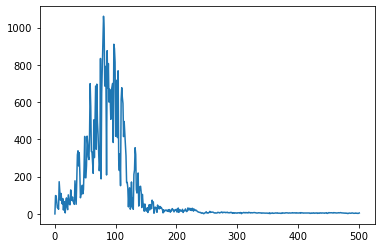

In [15]:
plt.plot(list(range(len(losses))), losses)

# 🏞 Downstream Task

### Dataset

In [23]:
eval_dataloader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=batch_size,
        num_workers=6,
        #drop_last=True,
        #shuffle=True,
)

### Prepare Model

In [16]:
backbone = moco.f_q

In [20]:
# freeze feature extractor
for param in backbone.parameters():
    param.requires_grad = False

In [22]:
backbone.fc = nn.Linear(C, len(dataset_train.classes))

### Train Linear Layer

In [26]:
for x, y in eval_dataloader:
    print(x)
    x = x.to(device)
    

[tensor([[[[-1.4158, -1.3473, -1.3987,  ..., -1.6727, -1.7583, -1.8439],
          [-1.3987, -1.3815, -1.3473,  ..., -1.7583, -1.7412, -1.8097],
          [-1.5528, -1.4329, -1.4158,  ..., -1.7412, -1.6898, -1.6727],
          ...,
          [-1.6384, -1.3987, -1.3473,  ..., -1.7583, -1.8097, -1.7412],
          [-1.7240, -1.7240, -1.5870,  ..., -1.8268, -1.6898, -1.6042],
          [-1.7240, -1.6898, -1.7583,  ..., -1.7925, -1.7240, -1.5185]],

         [[-1.3179, -1.2479, -1.3004,  ..., -1.6506, -1.6681, -1.7556],
          [-1.3004, -1.2829, -1.2479,  ..., -1.6681, -1.7206, -1.7906],
          [-1.4230, -1.3354, -1.3179,  ..., -1.7031, -1.7031, -1.7031],
          ...,
          [-1.5105, -1.3004, -1.2304,  ..., -1.6681, -1.7206, -1.6506],
          [-1.6331, -1.6331, -1.4755,  ..., -1.7206, -1.5805, -1.5105],
          [-1.6331, -1.5980, -1.6681,  ..., -1.6506, -1.5980, -1.4230]],

         [[-1.1421, -1.0724, -1.0898,  ..., -1.4384, -1.5081, -1.5779],
          [-1.1073, -1.0898, 

AttributeError: 'list' object has no attribute 'to'